In [1]:
!pip install -r requirements.txt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import time
import pandas as pd
import matplotlib.patches as patches
np.random.seed(42)


In [2]:
# Gaussian Mixture Model Parameters
# Pis
pi = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Means
means = [
    [-10.0, 0.0],
    [0.0, -10.0],
    [10.0, 0.0],
    [0.0, 10.0],
    [-5.0, 4.5],
    [5.0, 4.5],
    [0.0, -0.5],
    [0.0, -7.5],
    [-7.0, -5.5],
    [7.0, -5.5],
]

# Sigmas
covs = [
    [[0.1, 0.0], [0.0, 15.0]],
    [[15.0, 0.0], [0.0, 0.1]],
    [[0.1, 0.0], [0.0, 15.0]],
    [[15.0, 0.0], [0.0, 0.1]],
    [[3.0, 0.0], [0.0, 0.1]],
    [[1.0, 0.0], [0.0, 1.0]],
    [[0.1, 0.0], [0.0, 3.0]],
    [[4.0, 0.0], [0.0, 0.1]],
    [[0.5500000000000002, -0.45], [-0.45, 0.5499999999999999]],
    [[0.5500000000000002, 0.45], [0.45, 0.5499999999999999]],
]

In [3]:
# Generate synthetic data from the GMM
def generate_data(n_samples=1000):
    data = []
    labels = []
    for i, (mean, cov) in enumerate(zip(means, covs)):
        n = int(n_samples * pi[i])
        samples = np.random.multivariate_normal(mean, cov, n)
        data.append(samples)
        labels.extend([i] * n)
    return np.vstack(data), np.array(labels)


data, labels = generate_data()

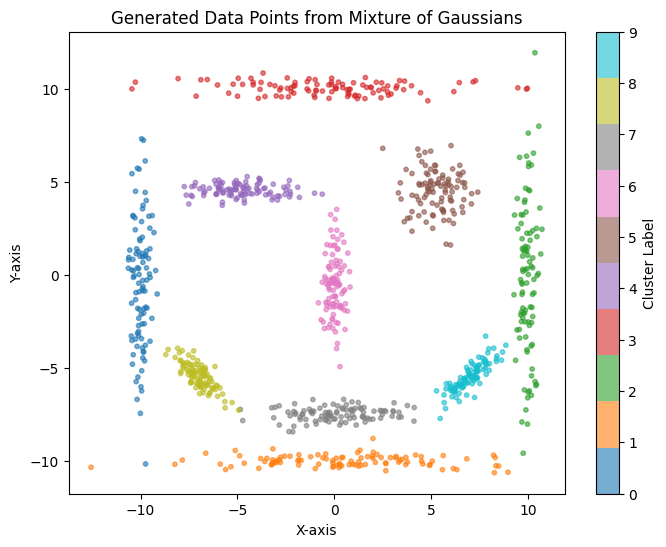

In [4]:
# Visualize the true distribution
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, c=labels, cmap="tab10", s=10)
plt.title("Generated Data Points from Mixture of Gaussians")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar(label="Cluster Label")

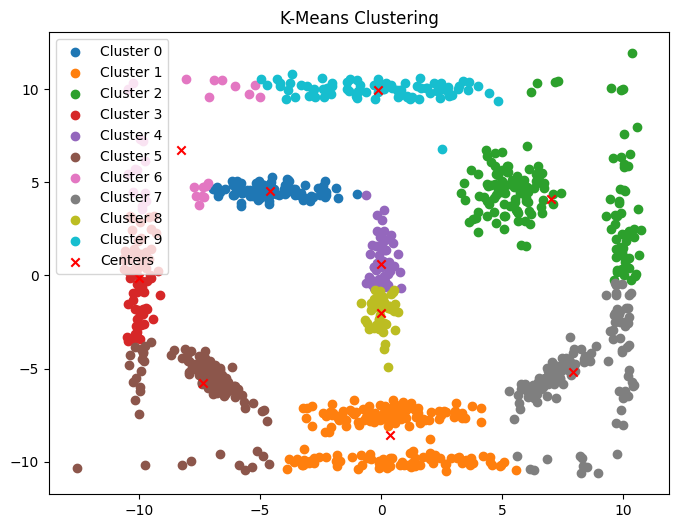

In [5]:
# 1. K-Means Clustering
def run_kmeans(data, n_clusters):
    np.random.seed(42)
    predictions = np.random.randint(0, n_clusters, size=len(data))
    centers = np.random.rand(n_clusters, data.shape[1])

    # TODO: Implement K-Means Algorithm
    
    max_iter = 700
    
    for _ in range(max_iter):
        distances = np.linalg.norm(data[:, np.newaxis] - centers, axis=2)  
        predictions = np.argmin(distances, axis=1)  
        new_centers = np.array([data[predictions == k].mean(axis=0) for k in range(n_clusters)])
        centers = new_centers
        
        

    centers = new_centers

    return predictions, centers

n_clusters = len(pi)
start_time = time.time()
kmeans_predictions, centers = run_kmeans(data, n_clusters)
kmeans_time = time.time() - start_time

# Plot K-Means Results
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(
        data[kmeans_predictions == i, 0], data[kmeans_predictions == i, 1], label=f"Cluster {i}"
    )
plt.scatter(centers[:, 0], centers[:, 1], c="red", marker="x", label="Centers")
plt.legend()
plt.title("K-Means Clustering")
plt.show()

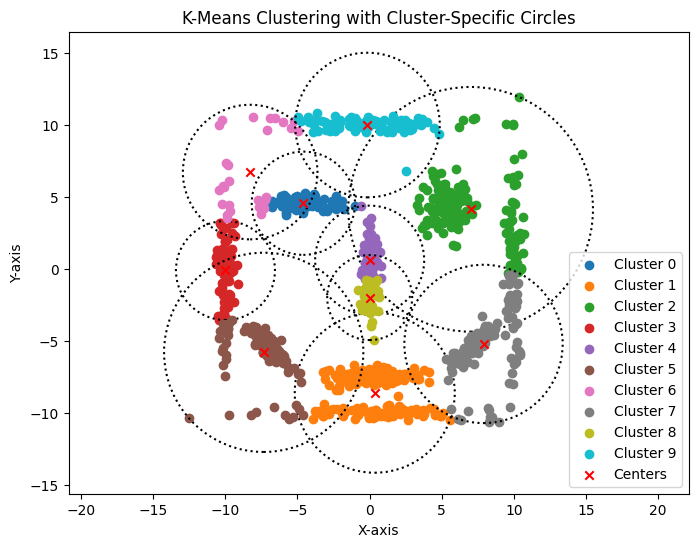

In [6]:
# This graph is added to visualize the circular nature of clusters formed by the K-Means algorithm,
# assuming clusters are spherical in structure.

plt.figure(figsize=(8, 6))

for i in range(n_clusters):
    cluster_data = data[kmeans_predictions == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {i}")
    
    center = centers[i]
    distances = np.linalg.norm(cluster_data - center, axis=1)
    radius = np.max(distances) 
    
    circle = patches.Circle(center, radius, color='black', fill=False, linestyle='dotted', linewidth=1.5)
    plt.gca().add_patch(circle)

plt.scatter(centers[:, 0], centers[:, 1], c="red", marker="x", label="Centers")

plt.legend()
plt.title("K-Means Clustering with Cluster-Specific Circles")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.axis("equal")   
plt.show()

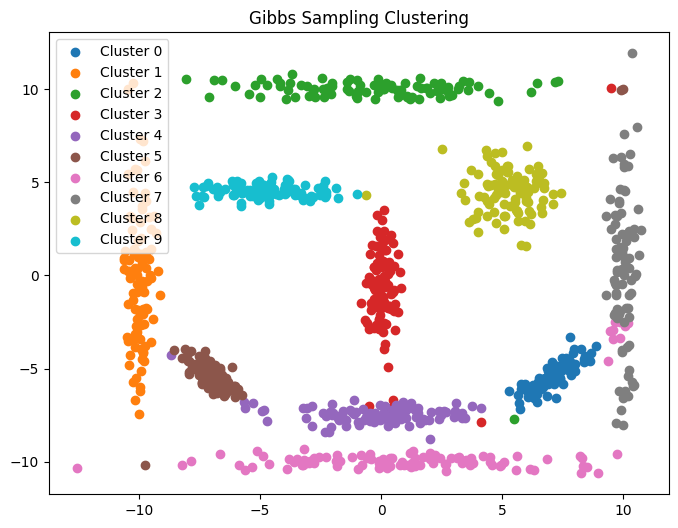

In [7]:
# 2. Gibbs Sampling for Clustering
def gibbs_sampling(data, n_clusters=10, n_samples=700, burn_in=200):
    np.random.seed(42)
    n_points, dim = data.shape
    np.random.seed(42)
    cluster_assignments = np.random.choice(n_clusters, n_points)
    
    #my code
    means = np.random.randn(n_clusters, dim)
    covariances = [np.eye(dim) for _ in range(n_clusters)]
    burn_in_assignments = []


    
    for step in range(n_samples):
        for i in range(n_points):
            probabilities = []
            for k in range(n_clusters):
                diff = data[i] - means[k]
                likelihood = np.exp(-0.5 * diff @ np.linalg.inv(covariances[k]) @ diff.T)
                likelihood /= np.sqrt((2 * np.pi) ** dim * np.linalg.det(covariances[k]))
                prior = 1 / n_clusters
                probabilities.append(likelihood * prior)
            probabilities = np.array(probabilities)
            probabilities /= probabilities.sum()
            cluster_assignments[i] = np.random.choice(n_clusters, p=probabilities)

        for k in range(n_clusters):
            points_in_cluster = data[cluster_assignments == k]
            if len(points_in_cluster) > 0:
                means[k] = points_in_cluster.mean(axis=0)
                covariances[k] = np.cov(points_in_cluster, rowvar=False)
            else:
                means[k] = np.random.randn(dim)
                covariances[k] = np.eye(dim)

        if step >= burn_in:
            burn_in_assignments.append(cluster_assignments.copy())

        


    return np.mean(burn_in_assignments, axis=0).astype(int)

start_time = time.time()
gibbs_predictions = gibbs_sampling(data, n_clusters)
gibbs_time = time.time() - start_time

# Plot Gibbs Sampling Results
plt.figure(figsize=(8, 6))
for i in range(len(pi)):
    plt.scatter(
        data[gibbs_predictions == i, 0],
        data[gibbs_predictions == i, 1],
        label=f"Cluster {i}",
    )
plt.title("Gibbs Sampling Clustering")
plt.legend()

plt.show()

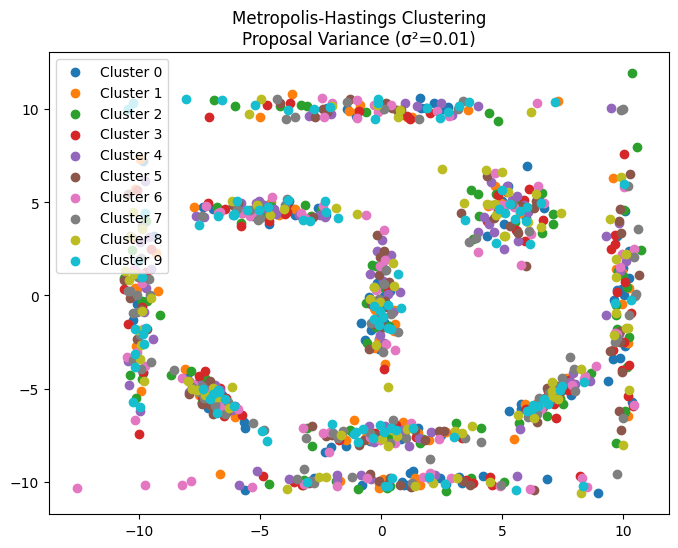

In [ ]:
# 3. Metropolis-Hastings for Clustering
def metropolis_hastings(data, n_clusters, sigma2, n_samples, burn_in):
    np.random.seed(42)
    n_points, dim = data.shape
    cluster_assignments = np.random.choice(n_clusters, n_points)

    #mycode
    proposal_std = np.sqrt(sigma2)
    means = np.random.randn(n_clusters, dim)
    covariances = [np.eye(dim) for _ in range(n_clusters)]
    burn_in_assignments = []
  

    for step in range(n_samples):
        for i in range(n_points):
            current_cluster = cluster_assignments[i]
            proposed_cluster = (current_cluster + int(np.random.normal(0, proposal_std))) % n_clusters

            current_diff = data[i] - means[current_cluster]
            proposed_diff = data[i] - means[proposed_cluster]

            epsilon = 1e-6
            current_cov = covariances[current_cluster] + epsilon * np.eye(dim)
            proposed_cov = covariances[proposed_cluster] + epsilon * np.eye(dim)

            current_likelihood = np.exp(-0.5 * current_diff @ np.linalg.inv(current_cov) @ current_diff.T)
            current_likelihood /= np.sqrt((2 * np.pi) ** dim * np.linalg.det(current_cov))

            proposed_likelihood = np.exp(-0.5 * proposed_diff @ np.linalg.inv(proposed_cov) @ proposed_diff.T)
            proposed_likelihood /= np.sqrt((2 * np.pi) ** dim * np.linalg.det(proposed_cov))

            acceptance_ratio = min(1, proposed_likelihood / current_likelihood)
            
            if np.random.rand() < acceptance_ratio:
                cluster_assignments[i] = proposed_cluster

        for k in range(n_clusters):
            points_in_cluster = data[cluster_assignments == k]
            if len(points_in_cluster) > 0:
                means[k] = points_in_cluster.mean(axis=0)
                covariances[k] = np.cov(points_in_cluster, rowvar=False) + epsilon * np.eye(dim)
            else:
                means[k] = np.random.randn(dim)
                covariances[k] = np.eye(dim)

        if step >= burn_in:
            burn_in_assignments.append(cluster_assignments.copy())

    return np.mean(burn_in_assignments, axis=0).astype(int)

proposal_variances = [0.01, 0.1, 1, 10,20,30]
n_clusters=10
n_samples=700
burn_in=200


mh_results = {}
mh_execution_times = {}
mh_ari_results = {}

for sigma2 in proposal_variances:
    start_time = time.time()
    mh_results[sigma2] = metropolis_hastings(data, n_clusters, sigma2,n_samples, burn_in)
    mh_execution_times[sigma2] = time.time() - start_time
    mh_ari_results[sigma2] = adjusted_rand_score(labels, mh_results[sigma2])

    # Plot Metropolis-Hastings Results
    plt.figure(figsize=(8, 6))
    for i in range(len(pi)):
        plt.scatter(
            data[mh_results[sigma2] == i, 0], data[mh_results[sigma2] == i, 1], label=f"Cluster {i}"
        )
    plt.title(f"Metropolis-Hastings Clustering\nProposal Variance (σ²={sigma2})")
    
    plt.legend()
    
    plt.show()

In [ ]:
kmeans_ari = adjusted_rand_score(labels, kmeans_predictions)
gibbs_ari = adjusted_rand_score(labels, gibbs_predictions)
mh_ari_results = {sigma2: adjusted_rand_score(labels, mh_results[sigma2]) for sigma2 in mh_results}

    
results = pd.DataFrame({
    "Method": ["K-Means", "Gibbs Sampling"] + [f"MH (σ²={sigma2})" for sigma2 in mh_results],
    "ARI": [kmeans_ari, gibbs_ari] + list(mh_ari_results.values()),
    "Execution Time (s)": [kmeans_time, gibbs_time] + list(mh_execution_times.values())
})

print("\nComparison of Clustering Methods:")
print(results)

In [ ]:
def metropolis_hastings(data, n_clusters, sigma2, n_samples, burn_in, target_ari=0.93, max_steps=4000):
    np.random.seed(42)
    n_points, dim = data.shape
    cluster_assignments = np.random.choice(n_clusters, n_points)

    proposal_std = np.sqrt(sigma2)
    means = np.random.randn(n_clusters, dim)
    covariances = [np.eye(dim) for _ in range(n_clusters)]
    burn_in_assignments = []
    ari = 0 
    
    for step in range(n_samples):
        for i in range(n_points):
            current_cluster = cluster_assignments[i]
            proposed_cluster = (current_cluster + int(np.random.normal(0, proposal_std))) % n_clusters

            current_diff = data[i] - means[current_cluster]
            proposed_diff = data[i] - means[proposed_cluster]

            epsilon = 1e-6
            current_cov = covariances[current_cluster] + epsilon * np.eye(dim)
            proposed_cov = covariances[proposed_cluster] + epsilon * np.eye(dim)

            current_likelihood = np.exp(-0.5 * current_diff @ np.linalg.inv(current_cov) @ current_diff.T)
            current_likelihood /= np.sqrt((2 * np.pi) ** dim * np.linalg.det(current_cov))

            proposed_likelihood = np.exp(-0.5 * proposed_diff @ np.linalg.inv(proposed_cov) @ proposed_diff.T)
            proposed_likelihood /= np.sqrt((2 * np.pi) ** dim * np.linalg.det(proposed_cov))

            acceptance_ratio = min(1, proposed_likelihood / current_likelihood)
            
            if np.random.rand() < acceptance_ratio:
                cluster_assignments[i] = proposed_cluster

        for k in range(n_clusters):
            points_in_cluster = data[cluster_assignments == k]
            if len(points_in_cluster) > 0:
                means[k] = points_in_cluster.mean(axis=0)
                covariances[k] = np.cov(points_in_cluster, rowvar=False) + epsilon * np.eye(dim)
            else:
                means[k] = np.random.randn(dim)
                covariances[k] = np.eye(dim)

        if step >= burn_in:
            burn_in_assignments.append(cluster_assignments.copy())

        
        if step >= burn_in:
            ari = adjusted_rand_score(labels, burn_in_assignments[-1])
            if ari >= target_ari:
                print(f"ARI reached {ari:.4f} at step {step}. Stopping early.")
                break  

        if step >= max_steps:
            print(f"Reached maximum steps ({max_steps}). Stopping.")
            break

    return np.mean(burn_in_assignments, axis=0).astype(int)


proposal_variances = [0.01, 0.1, 0.5]
n_clusters = 10
n_samples = 4000
burn_in = 200
target_ari = 0.93
max_steps = 4000

mh_results = {}
mh_execution_times = {}
mh_ari_results = {}

for sigma2 in proposal_variances:
    start_time = time.time()
    mh_results[sigma2] = metropolis_hastings(data, n_clusters, sigma2, n_samples, burn_in, target_ari, max_steps)
    mh_execution_times[sigma2] = time.time() - start_time
    mh_ari_results[sigma2] = adjusted_rand_score(labels, mh_results[sigma2])  
    print(f"Proposal Variance (σ²={sigma2}):")
    print(f"Execution Time: {mh_execution_times[sigma2]:.4f} seconds")
    print(f"ARI: {mh_ari_results[sigma2]:.4f}")
    print("-" * 50)
  
